In [2]:
#loading of the packages
import numpy as np
from scipy import ndimage
import skimage.io
from skimage import morphology
from skimage import filters
from skimage import transform
from skimage import draw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import random
import pandas as pd
import sys
import time
import pickle
import importlib
#custom packages
function_dir = os.path.join(os.pardir, 'Functions')
sys.path.append(function_dir)

import segmentation as seg
importlib.reload(seg) #to make sure the last version of seg is used


<module 'segmentation' from '..\\Functions\\segmentation.py'>

# Segmentation
In this notebook will be summarized the different approaches that I have tried to segment the images into separate plankton bundles. To get a good understanding of the working of the different algorithms, a set of images can be plugged through them:

In [7]:
data_paths = {}
#loading the images:
#from an open source dataset
data_base_path = os.path.join(os.pardir, 'Datasets')
data_folder_clean = os.path.join('PMID2019','JPEGImages')
data_paths['clean'] = os.path.join(data_base_path, data_folder_clean)

#from the planktoscope aquisition:
data_base_aqui = os.path.join('R:','3.Masters_projects','2021_Dominic_Rebindaine')
#feel free add another aquisition that you would like to test:
data_folder_volvox = os.path.join('20211105_Volvox_1','20211105_Volvox_1_138')
data_folder_see = os.path.join('20211104_Greifensee_1','20211104_Greifensee_1_121')
data_paths['volvox']=os.path.join(data_base_aqui,data_folder_volvox)
data_paths['Greifensee']=os.path.join(data_base_aqui,data_folder_see)

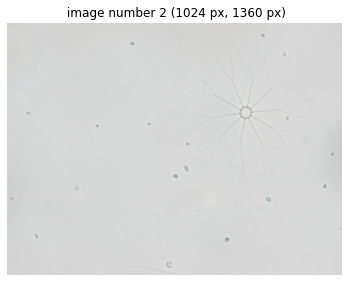

In [12]:
#show an example image from some a given dataset:
data_path = data_paths['clean']
i = 2#change value to change img

img = skimage.io.imread(os.path.join(data_path, os.listdir(data_path)[i]))
im_h, im_w, im_channel = img.shape
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')
ax.set_title(' image number '+str(i)+' ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()


## Algorithms
### 1. Clean images
The first segmentation algorithm was tested on an open source dataset, containing only clean images. This algorithm used a high pass, or sobel, filter to detect the sharp edges of the objects, and then used a morphological dilation to fuse close objects together. The objects too small to be real plankton are then discarded. Moreover, in order to speed up the calculation, the image is shrink before processing. This leaves 4 user parameters: the shrink factor, the threshold at which an edge is considered, the dilation size and the minimal size of the objects:

In [13]:
shrink_factor = 2 
threshold = 0.1
dil_size = 15
min_area  = 2000 #minimal area to filter out noise (in pixels, after dilation)

the preprocessing took: 
 - 0.007226600000194594s to shrink the image
 - 0.013607399999727932s to process the high pass filter
 - 0.0033415000002605666s to normalize the image
 - 0.0003741999998965184s to binarize it
 - 0.030973200000062207s to close it
 - 0.002364899999975023s to label it
 - 0.0044924999997419945s to filter it 
 ----TOTAL: 0.062380299999858835


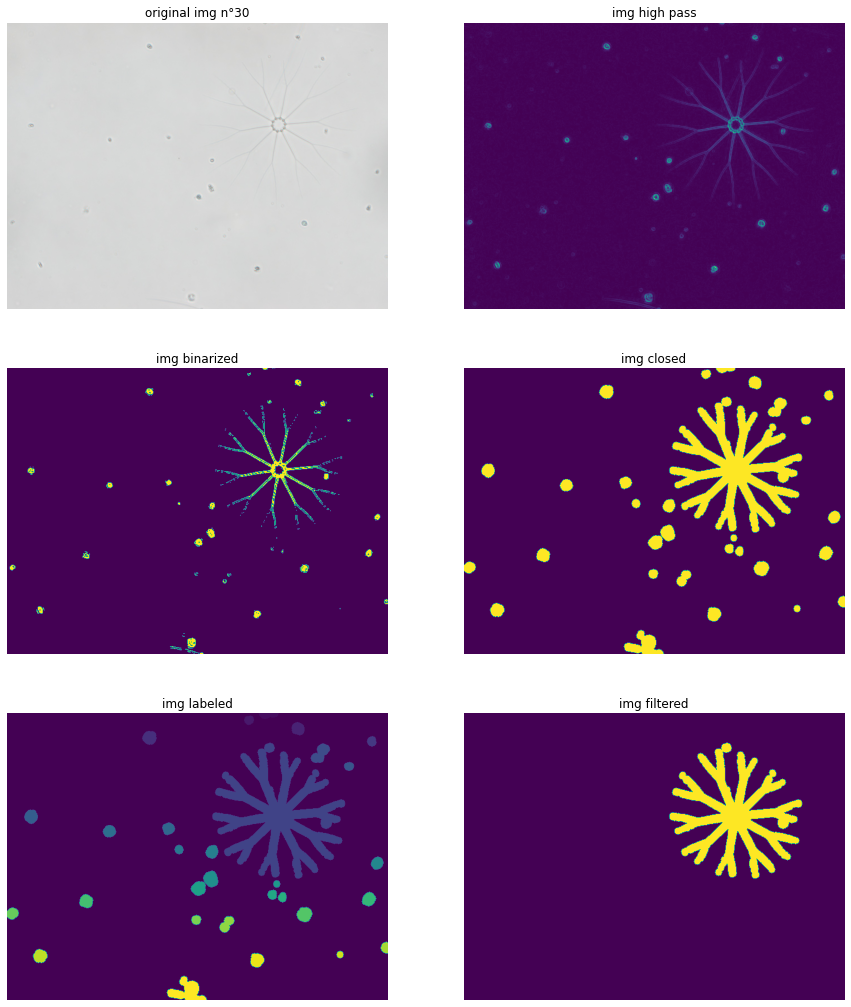

In [14]:
t0 = time.perf_counter()
#shrink the image to fasten the calculations, and turn it grey
img_small = np.sum(img[0::shrink_factor,0::shrink_factor],axis = 2)
t00 = time.perf_counter()
#sobel:
img_border = filters.sobel(img_small)
t1 = time.perf_counter()

#normalize the sobel filtered images
b_min = np.min(img_border)
b_max = np.max(img_border)
diff = b_max-b_min
img_bordern = (img_border-b_min)/diff
t2 = time.perf_counter()

#binarize
img_bin = img_bordern > threshold
t3 = time.perf_counter()

#morphological closing
img_close = morphology.binary_dilation(img_bin,selem = morphology.disk(6))
t4 = time.perf_counter()

#watershed
img_label, n_ROI = ndimage.label(img_close.astype(int))
t5 = time.perf_counter()

#filter out the parts too small to be an image as well as the background
ids, count = np.unique(img_label,return_counts = True)
new_ids = np.zeros((ids[-1]+1), dtype = int)
j = 0
for i,c in zip(ids,count):
    if c != np.max(count) and c > min_area:
            j = j+1
            new_ids[i]=j

#apply the filter:
if ids[-1]>1:
    img_filtered = new_ids[img_label[:,:]]
else:
    img_filtered = np.zeros(np.shape(img_label),dtype = int)
t6 = time.perf_counter()            


#print performances:
print('the preprocessing took: \n - '
     +str(t00-t0)+'s to shrink the image\n - '
     +str(t1-t00)+'s to process the high pass filter\n - '
     +str(t2-t1)+'s to normalize the image\n - '
     +str(t3-t2)+'s to binarize it\n - '
     +str(t4-t3)+'s to close it\n - '
     +str(t5-t4)+'s to label it\n - '
     +str(t6-t5)+'s to filter it \n ----TOTAL: '+str(t6-t0))

#plot
fig, ax = plt.subplots(3, 2, figsize=(15, 18))

ax[0,0].imshow(img)
ax[0,0].set_title('original img n°'+str(i))
ax[0,0].axis('off')

ax[0,1].set_title('img high pass')
ax[0,1].imshow(img_bordern)
ax[0,1].axis('off')

ax[1,0].set_title('img binarized')
ax[1,0].imshow(img_bin)
ax[1,0].axis('off')

ax[1,1].set_title('img closed')
ax[1,1].imshow(img_close)
ax[1,1].axis('off')

ax[2,0].set_title('img labeled')
ax[2,0].imshow(img_label)
ax[2,0].axis('off')

ax[2,1].set_title('img filtered')
ax[2,1].imshow(img_filtered)
ax[2,1].axis('off')
plt.show()


This pipeline of operation worked well on clean images, but if one try it with the images from the acquisition, the result would be quite unusable due to the noise present in them.

### 2. Noise Handling
The images in the acquisition presented 4 challenges:
* A radial hue shift coming from the sensor
* Static elements, like cracks in the flow chamber or dirt on the objectives
* Out of focus plankton
* A strobing effect creating darker and brighter bands on the images

To solve both the radial hue shift and the static elements, the fact that the setup was fixed was used to compute a flat image of the all the images from the acquisition. The mean image was tested at first, but the median image was later preferred, as it is less vulnerable to extreme values.

In [23]:
#chose an acquisition:
data_path = data_paths['volvox']
#chose an index to display:
i = 1

In [ ]:
# get all images from the folder in a list:
img_list =[]
for file in os.listdir(data_path):
    try:
        img_list.append(skimage.io.imread(os.path.join(data_path,file)))
    
    #something was not an image
    except:
        print("the file "+str(file)+" could not be open")
        continue
print("All images loaded")
img_arr = np.array(img_list)
med_img = np.median(img_arr,axis = 0)

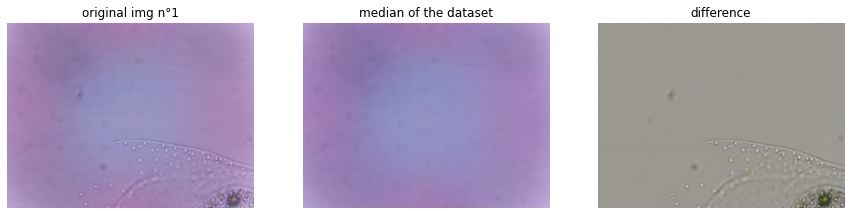

In [24]:
img = img_arr[i]
fig, ax = plt.subplots(1, 3, figsize=(15, 18))

ax[0].imshow(img)
ax[0].set_title('original img n°'+str(i))
ax[0].axis('off')
ax[1].imshow(med_img.astype(int))
ax[1].set_title('median of the dataset')
ax[1].axis('off')
diff = img-med_img
diff_rescale = (diff-np.min(diff))/(np.max(diff)-np.min(diff))
ax[2].imshow(diff_rescale)
ax[2].axis('off')
ax[2].set_title('difference')
plt.show()

As one can see, this method effectively remove the hue and the static dirt.
The difference image used latter on still faces the challenges of out of focus objects and of the strobing effect. After a careful setup of the camera during the acquisition phase, this effect could be reduced to the point of being negligible. 

The detection of out of focus objects, on the other hand, is more complex: it makes the algorithms of border detection unusable, and allows two distinct objects to be seemingly in close proximity while they are actually stacked with a large gap. The sharpness of an image should then be represented by a combination of spatial information and high frequencies. Continuous wavelet transforms were tried, using the reconstruction error at different scale to get information about the highest frequencies, but no ways to find a defining feature of "sharpness" were found that was working on a wide range of images of different shapes and sizes.

The preferred method was to use a sobel filter as well as a rank median filter to smoothen it. Such a high pass image can then be stored with the cropped region, and the sharpness can be extracted by its maximal (or 99th percentile, median, etc) value, and the cropped image could be separated if needed in the future.